# MAC0318 Introdução à Programação de Robôs Móveis

## Planejamento de movimento

Um problema planejamento de movimento é composto por

- Um espaço de trabalho $W$, particionado em espaço livre $W_\text{free}$ e espaço obstruído $W_\text{obst}$
- Uma função de ocupação que mapeia cada configuração do veículo em uma região do espaço de trabalho: $Occ: q \mapsto Occ(q) \subset W$
- Um espaço de configurações $C$, do qual obtemos o espaço de configurações livres $C_\text{free} = \{ q \in C \mid Occ(q) \subseteq W_\text{free} \}$
- Um funcional de custo $J(\tau)$ que associa a cada trajetória $\tau: [0,1] \rightarrow \mathbb{R}$ um valor real indicando uma penalidade
- Configurações inicial $q_i$ e final $q_f$

O Objetivo é encontrar uma solução para o seguinte problema de otimização
$$
\arg\min J(\tau) \text{ s.a. } \tau(0)=q_i, \tau(1)=q_f, \tau(\alpha) \in C_\text{free}
$$

## Plajenamento de trajetória para o robô diferencial no plano

No caso do robô de direção diferencial no plano, o problema de planejamento de movimento pode ser decomposto em duas etapas:

1. Determinar trajetória de referência $r(t)$, indicando a pose desejada para cada instante de tempo $t$
2. Determinar regra de controle $u(t)$ para seguir trajetória $r(t)$

A primeira etapa pode ser simplificada para fornecer como referência uma curva no plano, de forma que a segunda etapa se encarregue de projetar um controlador (PID) para um robô seguidor de tal trajetória. 

<figure style="text-align:center;">
    <img src="img/trajectory.png" width="600">
</figure>

Vamos assumir que a configuração do robô é dada por sua pose $q = \begin{bmatrix} x & y & \theta \end{bmatrix}$ e que os obstáculos são representados como polígonos, especificados por seus vértices. Vamos também desprezar as dimensões do robô, ou seja, vamos assumir um robô pontual e portanto que $Occ(q)=\begin{bmatrix} q_x & q_y \end{bmatrix}^t$. Essa hipótese pode ser removida aumentando-se as dimensões do obstáculos com as do robô (mas vamos ignorar tal passo aqui por simplicidade).

A etapa 1 pode ser então formalizada como:
- Espaço de trabalho $W \subseteq \mathbb{R}^2$ e espaço obstruído $W_\text{obst} = W_1 \cup \dotsb \cup W_m$, onde cada $W_j$ é um polígono especificado pela lista de vértices $v \in W$.
- Espaço de configuração $C=\text{SE}(2)$
- Custo $J(\tau)$ dado pelo comprimento da curva $\begin{bmatrix} q_x(\alpha) & q_y(\alpha) \end{bmatrix}^t$ para $q = \tau(\alpha)$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# Espaço de trabalho: região retangular
largura = 1189
altura = 841

In [3]:
# Obstáculos: lista de listas de vértices de polígonos
O = [
# L
 np.array(
     [[179.917,  74.083, 412.750, 470.958, 243.417, 296.333],   # Coordenadas x
      [338.667, 592.083, 703.792, 582.083, 497.417, 381.000]]), # Coordenadas y
# Triângulo
 np.array(
     [[793.750, 1095.375, 1079.5],
      [508.000,  730.250,  418.042]]),
# Pentágono
 np.array(
     [[518.583, 349.250, 497.417, 746.125, 719.667],
      [ 58.208, 248.708, 433.917, 391.583, 132.292]])
]

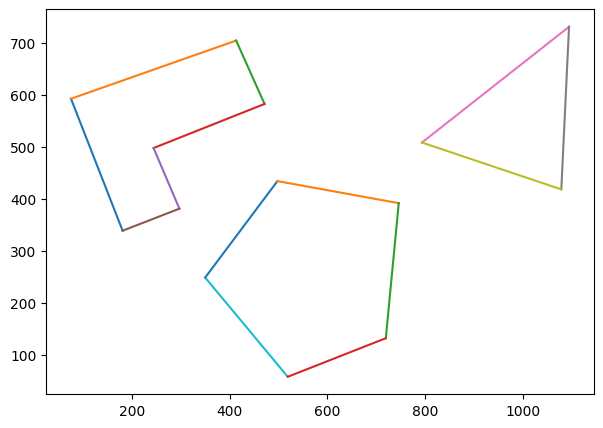

In [4]:
# Vamos exibir o espaço de configurações com os obstáculos
ar = largura/altura
plt.figure(figsize=(5*ar,5))
for o in O:
    for i in range(o.shape[1]-1):
        plt.plot([ o[0,i],o[0,i+1]], [o[1,i],o[1,i+1]])
    plt.plot([ o[0,-1],o[0,0]], [o[1,-1],o[1,0]])        

## Campos Potenciais

Nessa abordagem, encaramos o problema de planejamento de trajetória como o deslocamento de uma partícula pontual de massa $m$ sujeita a um campo potencial $U: \mathbb{R}^2 \rightarrow \mathbb{R}$. No instante $t$ a partícula ocupa uma posição $q_t \in \mathbb{R}^2$ e é sujeita a força
$$
F(q_t) = -\nabla U(q_t) \, .
$$

Se assumirmos que a particula possui massa unitária, a equação acima nos dá a aceleração da particula para a dada posição.

A função potencial é definida como a soma de $K$ potenticais locais: 
$$
U(q) = \sum_{i=1}^K U_i(q) \, .
$$
Cada potencial $U_i$ é da forma atratatora $U_\text{att}$, que faz a partícula a se locomover em sua direção, ou da forma repulsora $U_\text{rep}$, que faz a partícula se locomover na direção oposta.

### Potencial atrator

A forma mais simples de potencial atrativo se refere a um ponto atrator $a$, e é dado pela equação:
$$
U_\text{att}(q,a) = \frac{K_\text{att}}{2}|| q-a ||^2 \, ,
$$
onde $|| q || = \sqrt{q_x^2 + q_y^2}$ denote a norma de um vetor euclideano e $K_\text{att}$ é uma constante que regula a intensidade da atração.

In [5]:
# Potencial atrator de ponto a

k_att = 0.001

def U_att(x, y, a):
    " Potencial atrativo para ponto a. "
    dist = (x-a[0])**2 + (y-a[1])**2
    return 0.5*k_att*dist

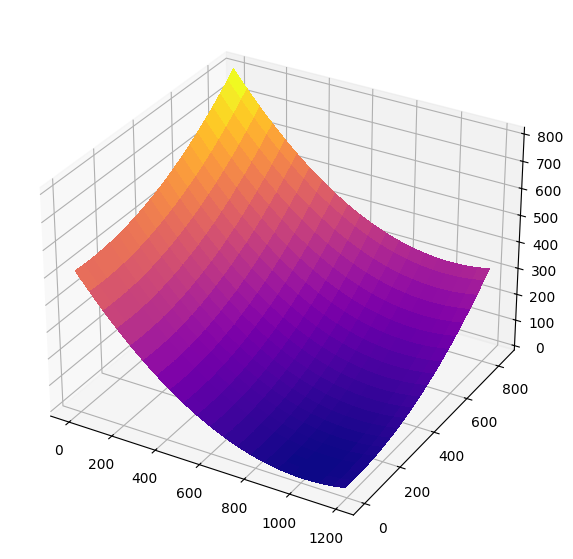

In [6]:
# Vamos calcular o potencial atrator ao ponto de destino

q_f   = np.array([1010, 70]) # posição final

# Vamos discretizar o espaço em pontos igualmente espaçados para visualização

xvalues = np.linspace(0,largura,100)

yvalues = np.linspace(0,altura,100)

xgrid, ygrid = np.meshgrid(xvalues, yvalues)

zvalues = U_att(xgrid, ygrid, q_f)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(7,7))
surf = ax.plot_surface(xgrid, ygrid, zvalues, cmap=cm.plasma, 
                       rstride=5, cstride=5, # use 1 a cada 5 pontos (por eficiência)
                       linewidth=0, antialiased=False);

### Potencial repulsor

O potencial respulsor em relação a um ponto $a$ é similar, exceto que ele decresce quadraticamente com o inverso da distância entre os pontos:

$$
U_\text{rep}(q,a) = \frac{K_\text{rep}}{2} \frac{1}{||q-a||^2} \, ,
$$
onde $K_\text{rep}$ é uma constante que regular a força. 

A função acima atribui um valor positivo em todo o espaço, embora desprezível para distâncias grandes. Para evitar que a soma de influências pequenas de um número grande de objetos se sobreponha a uma influência de um objeto próximo, podemos limitar a **zona de influência** do ponto a um raio $\rho$:
$$
U_\text{rep}(q,a) = \begin{cases} \frac{K_\text{rep}}{2} \left(\frac{1}{||q-a||}-\frac{1}{\rho}\right)^2 & \text{se } ||q-a|| \leq \rho\\
0 & \text{se } ||q-a|| > \rho \end{cases}
$$

O potencial repulsor em relação a um segmento de reta é dado pelo valor $U(q,n)$, onde $n$ é o ponto mais próximo ao segmento, ou seja, o ponto do segmento que minimiza $||q-n||$. Note que na fórmula acima só precisamos conhecer a distância entre $q$ e $n$. O potencial repulsor em relação a um obstáculo (polígono) é o valor $U(q,n)$ onde $n$ é o ponto de uma aresta do obstátculo mais próximo a $q$.


In [7]:
# Potencial repulsor de ponto a

k_rep = 500.0

rho = 50.0 # raio de influência

def U_rep_obs(x, y, o):
    " Potencial repulsivo para polígno o. "
    dist = np.Infinity*np.ones(x.shape)    
    # Encontra menor distância a aresta de polígono
    a = o[:,-1]
    for i in range(o.shape[1]):
        b = o[:,i]
        # projeção do ponto (x,y) na reta que passa por ab
        t = ((x-a[0])*(b[0]-a[0]) + (y-a[1])*(b[1]-a[1]))/((b[0]-a[0])**2 + (b[1]-a[1])**2)
        # limite nas extremidades do segmento
        t[t < 0] = 0.0
        t[t > 1] = 1.0
        # ponto n mais próximo na aresta
        nx = a[0] + t*(b[0]-a[0])
        ny = a[1] + t*(b[1]-a[1])
        # distância entre (x,y) e n
        d = np.sqrt((x-nx)**2 + (y-ny)**2)
        # menor distância a objeto?
        dist = np.minimum(d, dist)
        # próxima aresta
        a = b
    # Calcula potencial repulsivo
    u = 0.5*k_rep*(1/dist-1/rho)**2
    # valor fora do raio de influência deve ser zero
    u[ dist >= rho ] = 0.0
    return u

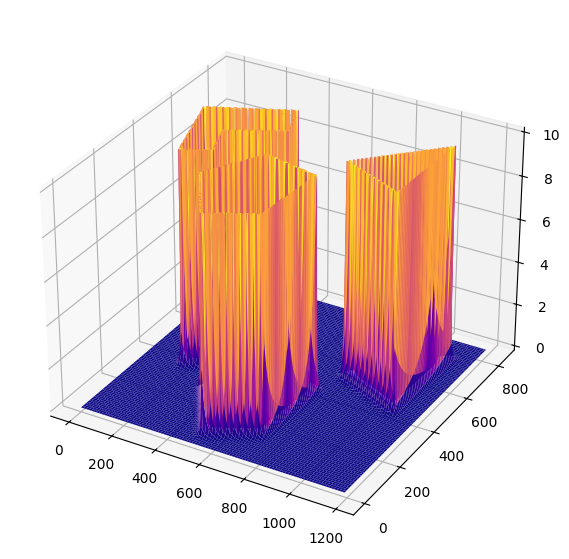

In [8]:
# Vamos calcular o potencial repulsor em relação a cada vértice dos polígonos

xvalues = np.linspace(0,largura,500)

yvalues = np.linspace(0,altura,500)

xgrid, ygrid = np.meshgrid(xvalues, yvalues)

zvalues = np.zeros(xgrid.shape)
for o in O:
    zvalues += U_rep_obs(xgrid, ygrid, o)

# print(zvalues.max()) # descomente para ver valor máximo da função

zvalues[zvalues > 10] = 10 # vamos limitar para poder visualizar melhor (valores de U tendem a infinito próximo a obstáculos)


fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(7,7))
surf = ax.plot_surface(xgrid, ygrid, zvalues, cmap=cm.plasma, 
                       rstride=5, cstride=5, # use 1 a cada 5 pontos (por eficiência)
                       linewidth=0, antialiased=True);

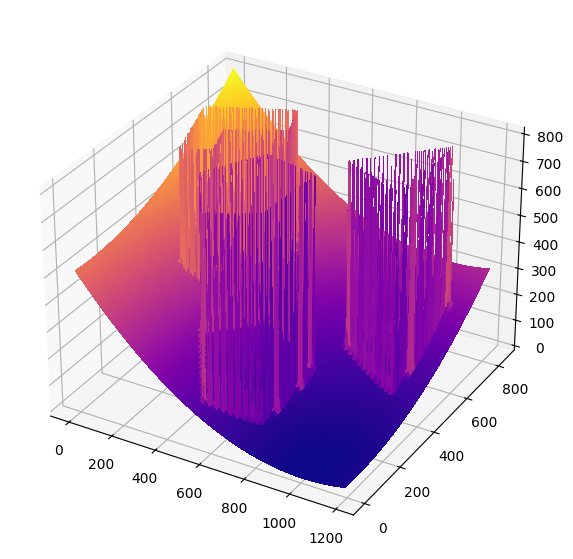

In [9]:
# Juntando tudo

k_att = 0.001

k_rep = 500.0

rho = 50.0 # raio de influência

# Discretização do espaço (para visualização)

xvalues = np.linspace(0,largura,500)

yvalues = np.linspace(0,altura,500)

xgrid, ygrid = np.meshgrid(xvalues, yvalues)

# Potencial atrator
zvalues = U_att(xgrid, ygrid, q_f)

cap = zvalues.max()

# Potencial repulsivo
for o in O:
    zvalues += U_rep_obs(xgrid, ygrid, o)

zvalues[zvalues > cap] = cap # vamos limitar para poder visualizar (valores de U tendem a infinito)


fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(7,7))
surf = ax.plot_surface(xgrid, ygrid, zvalues, cmap=cm.plasma, 
                       rstride=5, cstride=5, # use 1 a cada 5 pontos (por eficiência)
                       linewidth=0, antialiased=False);

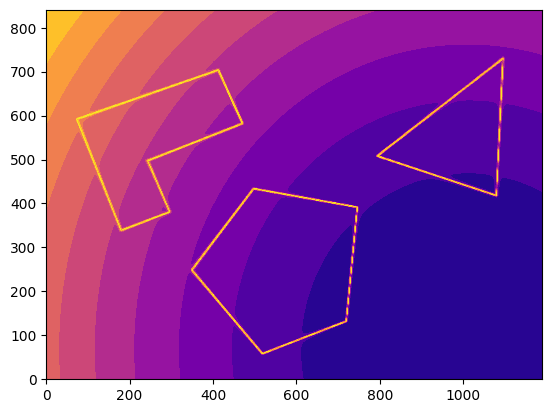

In [10]:
plt.contourf(xgrid,ygrid,zvalues,10, cmap=cm.plasma);

## Planejamento de trajetória por campo potencial

Trajetória é obtida como sequência de pontos obtidos pelo algoritmo de **descida do gradiente**:
$$
  q_{t+1} = q_t - \alpha \nabla U(q_t)
$$

O algoritmo converge para ponto estacionário $\nabla(q) = 0$. Na prática, terminamos o algoritmo quando $||\nabla|| < \epsilon$.

In [11]:
def grad(q):
    ''' Calcula gradiente de potencial no ponto q. '''
    # Potencial atrator (meta)
    G = k_att*(q-q_f)
    # Potenciais repulsores
    for o in O: # para cada obstáculo
        # Calcula distância de ponto q a objeto
        dist = np.Infinity
        a = o[:,-1]
        p = a[:] # ponto mais próximo
        for i in range(o.shape[1]):
            b = o[:,i]
            # projeção do ponto (x,y) na reta que passa por ab
            ab = b-a
            #print(q, a, b, ab, q-a, np.dot(q-a,ab), np.dot(ab,ab))
            t = np.dot(q-a,ab)/np.dot(ab,ab)
            #print(t)
            if 0 < t < 1:
                n = a + t*ab
            elif t < 0:
                n = a
            else:
                n = b
            d = np.sqrt(np.dot(q-n,q-n))
            if d < dist:
                dist = d
                p = n[:]
            # próxima aresta
            a = b
        # Calcula potencial repulsivo
        if dist < rho: # se dentro do raio de influência
            G -= k_rep*(1/dist-1/rho)*(q-p)/dist**3
    return G

1019 iterações.


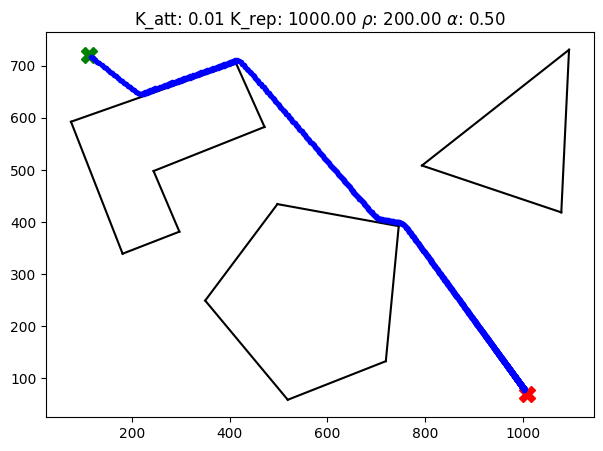

In [12]:
q_i   = np.array([110, 720]) # posição inicial

q_f   = np.array([1010, 70]) # posição final (desejada)

k_att = 0.01 # constante de atração

k_rep = 1000.0 # constante de repulsão

rho = 200.0 # raio de influência

a = 0.5 # tamanho do passo

# Vamos exibir os obstáculos e posições inicial e final
ar = largura/altura
plt.figure(figsize=(5*ar,5))
plt.title(rf"K_att: {k_att:.2f} K_rep: {k_rep:.2f} $\rho$: {rho:.2f} $\alpha$: {a:.2f}")
for o in O:
    for i in range(o.shape[1]-1):
        plt.plot([ o[0,i],o[0,i+1]], [o[1,i],o[1,i+1]], color='k')
    plt.plot([ o[0,-1],o[0,0]], [o[1,-1],o[1,0]], color='k') 
plt.plot(q_i[0], q_i[1], color='g', marker='X', markersize=12);
plt.plot(q_f[0], q_f[1], color='r', marker='X', markersize=12);

# Descida do gradiente

q = q_i[:]
g = grad(q)
k = 0
while np.dot(g,g) > 0.01:
    q = q - a*g
    plt.plot(q[0], q[1], color='b', marker='o', markersize=3);
    g = grad(q)
    k += 1
    if k > 10000: # evita laço infinito
        break
print(f"{k} iterações.")

### 💡Sua vez

Modifique os parâmetros do algoritmo ($K_\text{att}$, $K_\text{rep}$, $\rho$, $\alpha$) e reflita sobre as mudanças na trajetórias obtidas. Considere aspectos como:

- Número de iterações (= pontos da trajetória)
- Distância mínima aos obstáculos
- Convergência (chegou na meta?) e instabilidade (movimentos bruscos ou inválidos)

## $K_{att}$
Subir muito o valor deixa a particula instavel, pois acaba as vezes por entrar dentro dos objetos (que nao deveria) pelo movimento ser discreto. Tem alto impacto na quantidade de passos

## $K_{rep}$
Tem pouco impacto na quantidade de passos mas influencia bastante na rota tomada pelo robo. Se colocarmos um $K_{rep}$ muito alto podemos acabar por fechar alguns caminhos ou criar minimos locais

## $\\rho$ (Raio de Influência)
O parâmetro $\\rho$ define a **zona de influência** dos obstáculos, determinando até que distância um obstáculo exerce força repulsiva sobre o robô.

- **$\\rho$ muito grande**: O robô "enxerga" obstáculos distantes desnecessariamente, causando:
  - Trajetórias excessivamente longas e conservadoras
  - Criação de mínimos locais onde o robô pode ficar "preso"
  - Bloqueio de passagens estreitas navegáveis

## $\\alpha$ (Tamanho do Passo)
O parâmetro $\alpha$ controla o **tamanho do passo** no algoritmo de gradiente descendente ($q_{t+1} = q_t - \alpha \nabla U(q_t)$), determinando quão longe o robô se move a cada iteração.
- **$\\alpha$ muito pequeno**: 
  - Convergência lenta, exigindo muitas iterações
  - Trajetória suave mas computacionalmente custosa
  - Dificuldade para escapar de mínimos locais
- **$\\alpha$ muito grande**:
  - Instabilidade numérica e oscilações
  - Robô pode "saltar" sobre obstáculos devido ao movimento discreto
  - Risco de divergência do algoritmo



## Executando o plano

Vamos agora projetar um controlador para executar a trajetória. A trajetória gerada pode ser fornecida como referência estática, e controlada por um seguidor de linha ou pode ser computada dinâmicamente em relação a pose do robô em cada instante. Vamos adotar essa segunda abordagem, que aproveita a capacidade de campos potenciais fazerem planejamento em ambientes dinâmicos de maneira eficiente.

Nossa abordagem será projetar um controlador de seguidor de ponto:
$$
u(t) = \begin{bmatrix} v \\ \omega \end{bmatrix} = \begin{bmatrix} K_v d \\ K_a \gamma \end{bmatrix} \, ,
$$
onde $d$ e $\gamma$ são a distância e o ângulo em relação à pose atual ao ponto dado pela regra do gradiente no próximo instante ($q_{t+1} = q_t - \alpha \nabla U(q_t)$), e $K_v$ e $K_a$ sãoos ganhos do controlador proporcional.

In [13]:
from DifferentialDrive import DifferentialRobot

In [23]:
robot = DifferentialRobot(x0 = np.array([110., 720., .0]), max_speed=30., max_acc=100.) # pose inicial

q_f   = np.array([1010, 70]) # posição final (desejada)

k_att = 0.031 # constante de atração

k_rep = 8000.0 # constante de repulsão

rho = 300.0 # raio de influência

a = 0.9 # tamanho do passo

Kv = 1.1 # ganho do controlador proporcional para a velocidade
Ka = 5. # ganho do controlador proporcional para a taxa de rotação

it = 0
while True:
    # Localização: obtenha posição da pose do robô
    q = np.array([robot.x[0], robot.x[1]])    
    # Cálculo do gradiente
    g = grad(q)
    if np.dot(g,g) < 0.01: # se próximo a ponto estacionário, pare
        print('Chegou em ponto estacionário')        
        break        
    m = q - a*g # m é ponto de referência a ser seguido
    # seguir ponto m
    d = np.sqrt(np.dot(q-m,q-m)) # distância a ponto
    theta = np.arctan2(m[1]-q[1],m[0]-q[0])-robot.x[2] # ângulo entre orientação e ponto    
    # enviar sinal controle
    robot.forward(Kv*d, Ka*theta)     
    it += 1
    if it > 10000: # evita laço infinito
        print('No. max. de iterações alcançado')
        break   
        
print('Posição final:', robot.x)
print('Iterações:', it)

Chegou em ponto estacionário
Posição final: [ 1.00805930e+03  7.25662093e+01 -9.23268458e-01]
Iterações: 2027


In [24]:
robot.plot();

<IPython.core.display.Javascript object>

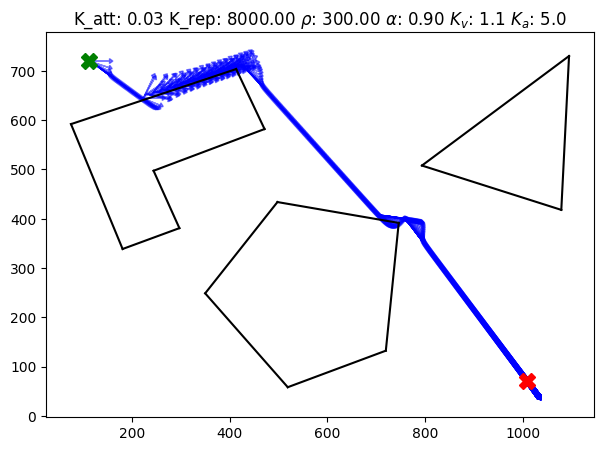

In [25]:
# Vamos exibir a trajetória executada
%matplotlib inline

ar = largura/altura
fig = plt.figure(figsize=(5*ar,5))
plt.title(rf"K_att: {k_att:.2f} K_rep: {k_rep:.2f} $\rho$: {rho:.2f} $\alpha$: {a:.2f} $K_v$: {Kv} $K_a$: {Ka}")
for o in O:
    for i in range(o.shape[1]-1):
        plt.plot([ o[0,i],o[0,i+1]], [o[1,i],o[1,i+1]], color='k')
    plt.plot([ o[0,-1],o[0,0]], [o[1,-1],o[1,0]], color='k') 
plt.plot(q_i[0], q_i[1], color='g', marker='X', markersize=12);
plt.plot(q_f[0], q_f[1], color='r', marker='X', markersize=12);
for x in robot.x_hist:
    plt.arrow(x[0], x[1], 50*np.cos(x[2]), 50*np.sin(x[2]), length_includes_head=True, head_width=10, head_length=7, color='b', alpha=0.5)    

In [26]:
# Podemos visualizar a trajetória em forma de vídeo

%matplotlib notebook
from IPython import display  
import matplotlib.animation as animation

def animate(i):
    line.set_data([robot.x_hist[i][0]], [robot.x_hist[i][1]])
    return line, 

ar = largura/altura
fig = plt.figure(figsize=(5*ar,5))
for o in O:
    for i in range(o.shape[1]-1):
        plt.plot([ o[0,i],o[0,i+1]], [o[1,i],o[1,i+1]], color='k')
    plt.plot([ o[0,-1],o[0,0]], [o[1,-1],o[1,0]], color='k') 
plt.plot(q_i[0], q_i[1], color='g', marker='X', markersize=12);
plt.plot(q_f[0], q_f[1], color='r', marker='X', markersize=12);
line, = plt.plot(robot.x_hist[0][0], robot.x_hist[0][1], color='b', marker='o', markersize=5)

ani = animation.FuncAnimation(
    fig, animate, len(robot.x_hist), interval=robot.dt*100, blit=True) # modifique o valor 100 para aumentar/diminuir tempo de animação
# ani.save("movie.mp4") # descomente para salvar vídeo
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.show()

<IPython.core.display.Javascript object>

### 💡Sua vez

Modifique os ganhos do controlador e reflita sobre as mudanças na trajetória obtida. Considere aspectos como:

- Instabilidade do robô
- Suavidade dos movimentos (acelerações linear e angular)
- Erro em regime
- Erro proporcional próxima à meta

Sugira melhorias para tornar a trajetória mais suave e curta.

# Melhorias Possiveis
Como melhorias possiveis podemos aumentar um pouco a atracao, mantendo a repulsao (ou aumentando, ja que a repulsao pouco interfere na quantidade de steps) para que o robo seja puxado mais fortemente pelo ponto final